In [52]:
import GPy
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import ToUndirected
from torch_geometric.utils import to_undirected
from torch_geometric_temporal.signal import temporal_signal_split
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
torch.manual_seed(seed)
torch.random.manual_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'


torch.Size([50, 1]) torch.Size([50, 1]) torch.Size([50, 1])


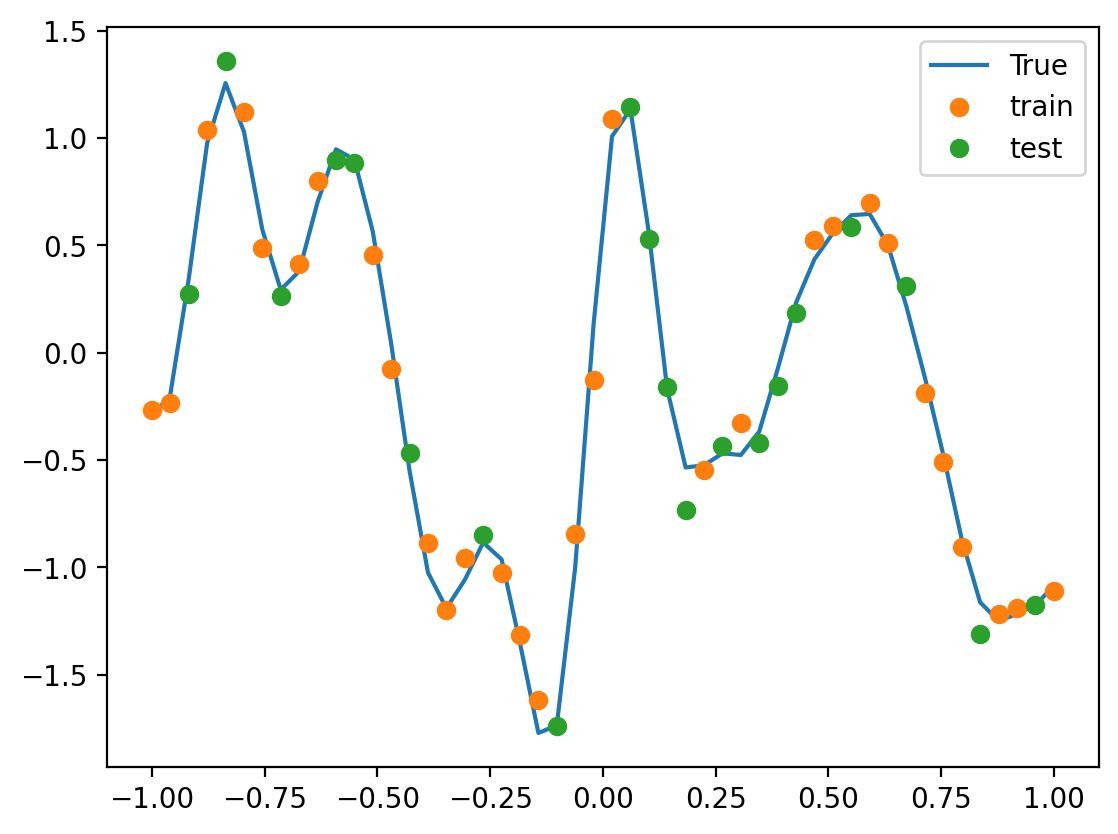

In [53]:
N = 50
x = np.linspace(-1, 1, N).reshape(-1, 1)
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=0.1)
y = np.random.multivariate_normal(np.zeros(N), kernel.K(x)).reshape(-1, 1)
y_noisy = y + np.random.normal(0, 0.1, N).reshape(-1, 1)

train_x, test_x, train_y, test_y = train_test_split(x, y_noisy, test_size=0.4, random_state=0)

plt.plot(x, y, label="True");
plt.plot(train_x, train_y, 'o', label='train')
plt.plot(test_x, test_y, 'o', label='test')
plt.legend();

x, y, y_noisy = map(lambda x: torch.tensor(x).float().to(device), (x, y, y_noisy))
train_x, test_x, train_y, test_y = map(lambda x: torch.tensor(x).float().to(device), (train_x, test_x, train_y, test_y))
print(x.shape, y.shape, y_noisy.shape)

In [59]:
train_x.shape

torch.Size([30, 1])

In [54]:
def get_eucledean_A(x, exponent):
    d = ((x[:, None] - x)**2).sum(axis=2)**0.5
    # self distance is 0, so replace it with twice of the max distance to give most importance to the current
    d = torch.where(d==0, torch.max(d[d!=0])*2, d)  
    A = 1/(d**exponent)
    return A/A.sum(dim=1, keepdim=True)


In [55]:
def adjacency_matrix_to_edge_list(A):
    edge_list = []
    edge_weights = []
    num_nodes = A.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_weights.append(A[i, j])
            if A[i, j] != 0:
                edge_list.append((i, j))
    
    return torch.tensor(edge_list).T.to(device), torch.tensor(edge_weights).to(device)


In [57]:
edge_list, edge_weights = adjacency_matrix_to_edge_list(get_eucledean_A(train_x, 1))

In [15]:
N = 1
D = 2  # Number of dimensions
x = np.random.randn(N, D)

y = np.random.multivariate_normal(np.zeros(N), kernel.K(x)).reshape(-1, 1)
y_noisy = y + np.random.normal(0, 0.1, (N, 1))


In [49]:
kernel = GPy.kern.RBF(input_dim=D, variance=1, lengthscale=0.8)

In [50]:
import matplotlib.pyplot as plt

# Define the grid
w1 = np.linspace(-3, 3, 50)
w2 = np.linspace(-3, 3, 50)
W1, W2 = np.meshgrid(w1, w2)
W1_flat = W1.reshape(-1, 1)
W2_flat = W2.reshape(-1, 1)
X = np.hstack((W1_flat, W2_flat))
y = np.random.multivariate_normal(np.zeros(2500), kernel.K(X)).reshape(50, 50)


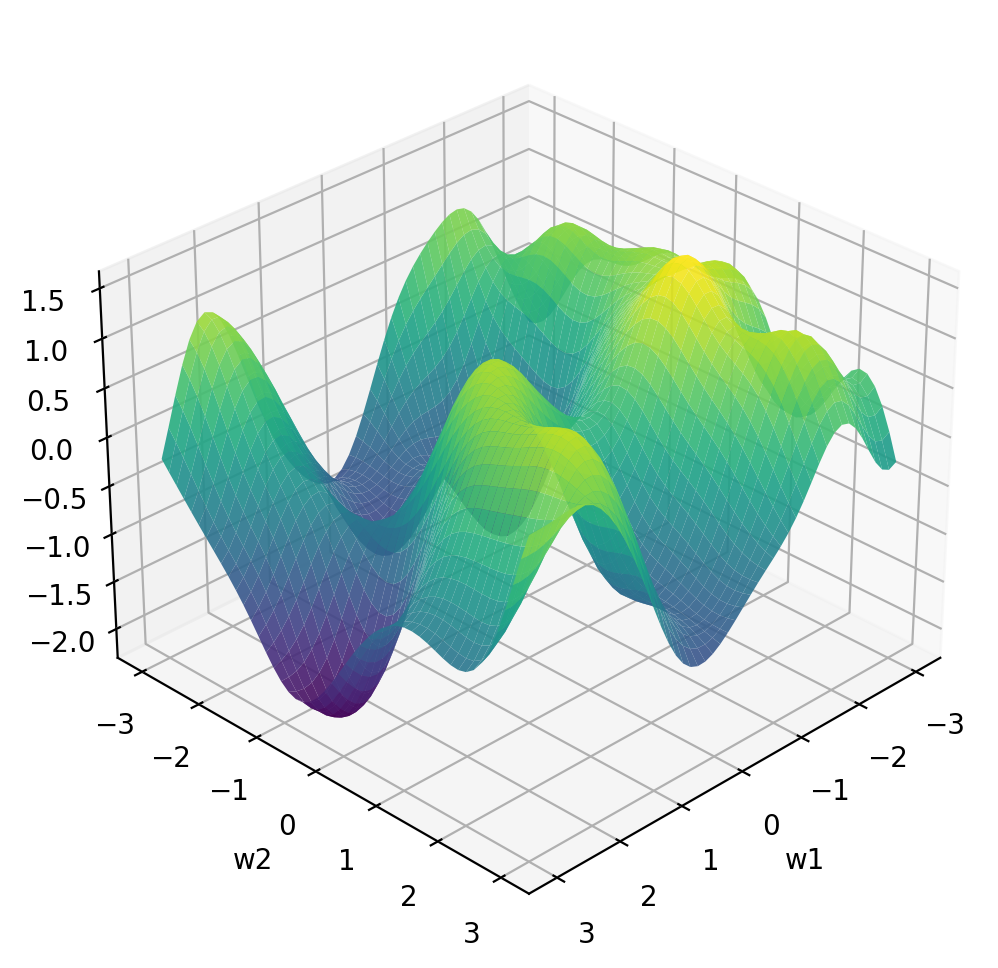

In [51]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W1, W2, y, cmap="viridis", alpha=0.9)
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.view_init(30, 45)
plt.show()

array([[0.5    , 0.45   , 0.405  , 0.3645 , 0.32805],
       [0.45   , 0.5    , 0.45   , 0.405  , 0.3645 ],
       [0.405  , 0.45   , 0.5    , 0.45   , 0.405  ],
       [0.3645 , 0.405  , 0.45   , 0.5    , 0.45   ],
       [0.32805, 0.3645 , 0.405  , 0.45   , 0.5    ]])

y=array([-0.24450766,  0.71878464,  0.45031305,  0.35116837,  0.03835798])


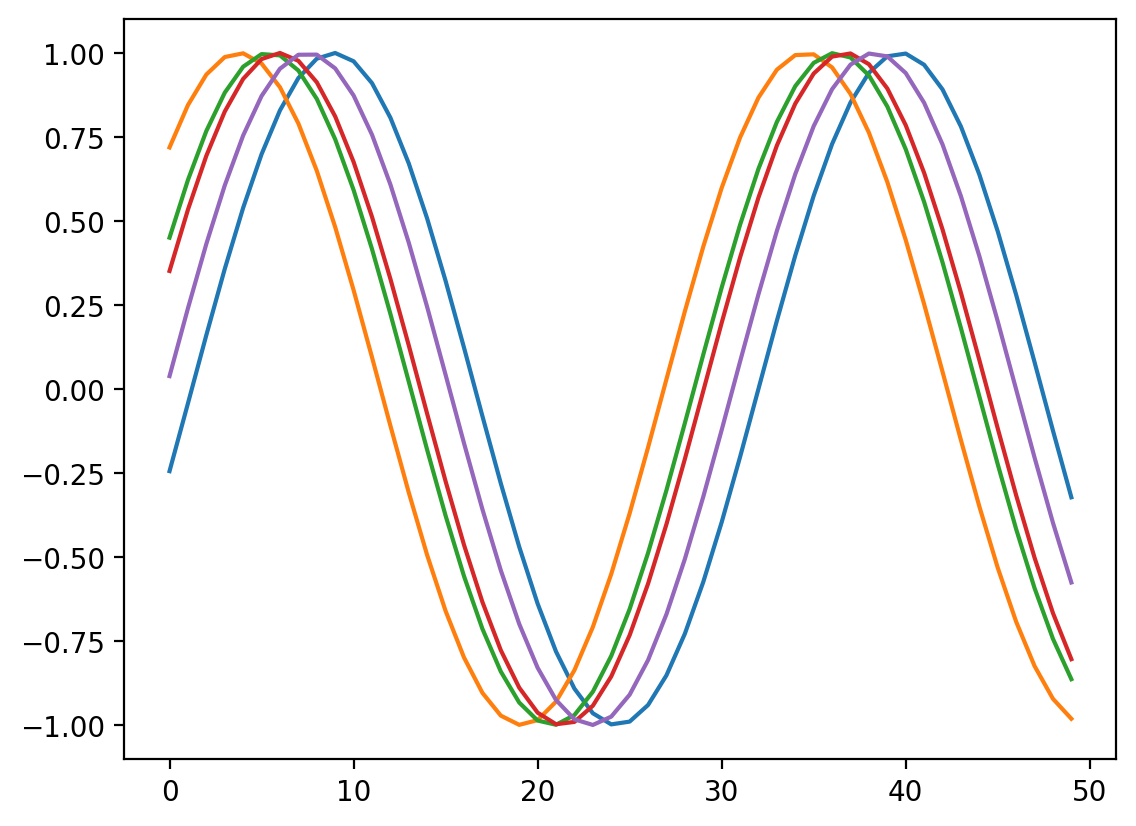

In [45]:
covariance_matrix = np.zeros((5, 5))
variance = 0.5

for i in range(5):
    for j in range(5):
        covariance_matrix[i, j] = 0.9 ** abs(i - j)

covariance_matrix = variance * covariance_matrix

display(covariance_matrix)

np.random.seed(2)
y = np.random.multivariate_normal(np.zeros(5), covariance_matrix)
print(f"{y=}")
angles = np.arcsin(y)
offsets = np.linspace(0, 10)
angles_matrix = angles.reshape(1, -1) + offsets.reshape(-1, 1)
data_matrix = np.sin(angles_matrix)

_ = plt.plot(data_matrix)